####AIM-  to predict the probability of an advertisement impression leading to an app installation.


##Step 1: Setting up the Environment
* Install necessary libraries.
* Authenticate and set up the Google Drive to download the datasets.

In [1]:
#Mounting Drive to store data files temporarily
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

##Step 2: Data Loading
Download and Load the data into pandas DataFrames for preliminary analysis.

In [3]:
#Downloading the data files using PyDrive
'''!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

TRAIN_DATA_PATH = 'train_data.csv'
ASSESSMENT_DATA_PATH = 'assessment_data.csv'

downloaded = drive.CreateFile({'id':"1N3n7ThL-4mRod-lwgy047LkFeZ5iGFuJ"})
downloaded.GetContentFile(TRAIN_DATA_PATH)
print(f'Downloaded: {TRAIN_DATA_PATH}')

downloaded = drive.CreateFile({'id':"1BCQuIIE-Kh61ExDuhWNLOPae-9Q3m6IL"})
downloaded.GetContentFile(ASSESSMENT_DATA_PATH)
print(f'Downloaded: {ASSESSMENT_DATA_PATH}')'''

'!pip install PyDrive\n\nfrom pydrive.auth import GoogleAuth\nfrom pydrive.drive import GoogleDrive\nfrom google.colab import auth\nfrom oauth2client.client import GoogleCredentials\n\nauth.authenticate_user()\ngauth = GoogleAuth()\ngauth.credentials = GoogleCredentials.get_application_default()\ndrive = GoogleDrive(gauth)\n\nTRAIN_DATA_PATH = \'train_data.csv\'\nASSESSMENT_DATA_PATH = \'assessment_data.csv\'\n\ndownloaded = drive.CreateFile({\'id\':"1N3n7ThL-4mRod-lwgy047LkFeZ5iGFuJ"})\ndownloaded.GetContentFile(TRAIN_DATA_PATH)\nprint(f\'Downloaded: {TRAIN_DATA_PATH}\')\n\ndownloaded = drive.CreateFile({\'id\':"1BCQuIIE-Kh61ExDuhWNLOPae-9Q3m6IL"})\ndownloaded.GetContentFile(ASSESSMENT_DATA_PATH)\nprint(f\'Downloaded: {ASSESSMENT_DATA_PATH}\')'

## Data description

- ```id```: impression id
- ```timestamp```: time of the event in UTC
- ```campaignId```: id of the advertising campaign (the game being advertised)
- ```platform```: device platform
- ```softwareVersion```: OS version of the device
- ```sourceGameId```: id of the publishing game (the game being played)
- ```country```: country of user
- ```startCount```: how many times the user has started (any) campaigns
- ```viewCount```: how many times the user has viewed (any) campaigns
- ```clickCount```: how many times the user has clicked (any) campaigns
- ```installCount```: how many times the user has installed games from this ad network
- ```lastStart```: last time user started any campaign
- ```startCount1d```: how many times user has started (any) campaigns within the last 24 hours
- ```startCount7d```: how many times user has started (any) campaigns within the last 7 days
- ```connectionType```: internet connection type
- ```deviceType```: device model
- ```install```: binary indicator if an install was observed (install=1) or not (install=0) after impression

###Here I have downloaded the file and then reading it. Please feel free to uncomment the download code and comment the saving file code while running if you dont have data files already installed.

In [5]:
#Code to save the data files
'''trainDF.to_csv("/content/drive/MyDrive/Colab Notebooks/trainDF.csv");
assessmentDF.to_csv("/content/drive/MyDrive/Colab Notebooks/assessmentDF.csv");'''

'trainDF.to_csv("/content/drive/MyDrive/Colab Notebooks/trainDF.csv");\nassessmentDF.to_csv("/content/drive/MyDrive/Colab Notebooks/assessmentDF.csv");'

In [4]:
#Reading the data files from drive
TRAIN_DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/trainDF.csv'
ASSESSMENT_DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/assessmentDF.csv'
trainDF = pd.read_csv(TRAIN_DATA_PATH, index_col=0)
assessmentDF = pd.read_csv(ASSESSMENT_DATA_PATH,index_col=0)

##Step 3: Exploratory Data Analysis (EDA)
* Perform EDA to understand the features and target variable distribution.
* Looking for any patterns, anomalies, or data issues.
* Visualizing different aspects of the data.

In [6]:
#Showing the columns in the data files respectively
print(trainDF.columns)
print(assessmentDF.columns) #No install column since have to use to predict

Index(['id', 'timestamp', 'campaignId', 'platform', 'softwareVersion',
       'sourceGameId', 'country', 'startCount', 'viewCount', 'clickCount',
       'installCount', 'lastStart', 'startCount1d', 'startCount7d',
       'connectionType', 'deviceType', 'install'],
      dtype='object')
Index(['id', 'timestamp', 'campaignId', 'platform', 'softwareVersion',
       'sourceGameId', 'country', 'startCount', 'viewCount', 'clickCount',
       'installCount', 'lastStart', 'startCount1d', 'startCount7d',
       'connectionType', 'deviceType'],
      dtype='object')


In [7]:
# Basic Information
print(trainDF.info())
print(assessmentDF.info())

categorical_columns = ['platform','softwareVersion','country','connectionType','deviceType'] #not considering IDs
numerical_columns = ['startCount','viewCount','clickCount','installCount','startCount1d','startCount7d']

target_var ='install'
categorical_columns.append('install')
numerical_columns.append('install')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3738763 entries, 0 to 3738762
Data columns (total 17 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   timestamp        object
 2   campaignId       object
 3   platform         object
 4   softwareVersion  object
 5   sourceGameId     int64 
 6   country          object
 7   startCount       int64 
 8   viewCount        int64 
 9   clickCount       int64 
 10  installCount     int64 
 11  lastStart        object
 12  startCount1d     int64 
 13  startCount7d     int64 
 14  connectionType   object
 15  deviceType       object
 16  install          int64 
dtypes: int64(8), object(9)
memory usage: 513.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3739968 entries, 0 to 3739967
Data columns (total 16 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   timestamp        object
 2   campaignId       object
 3   platform        

The training data contains 3738763 instances with 16 features and the corresponding responses $y \in \{0,1\}$  indicates whether install was observed (install=1) or was not observed (install=0) after impression. The data set is very unbalanced as the occurrence of an install event is only $\%1.2$.

In [8]:
# Descriptive statistics for numerical columns
print(trainDF.describe())
print(assessmentDF.describe())

       sourceGameId    startCount     viewCount    clickCount  installCount  \
count  3.738763e+06  3.738763e+06  3.738763e+06  3.738763e+06  3.738763e+06   
mean   3.201968e+06  4.839151e+01  3.602502e+01  2.074696e+00  5.652519e-01   
std    1.425577e+07  9.061205e+01  7.925836e+01  6.795765e+00  1.538061e+00   
min    1.105500e+04  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.222943e+06  6.000000e+00  2.000000e+00  0.000000e+00  0.000000e+00   
50%    1.634195e+06  1.900000e+01  1.000000e+01  0.000000e+00  0.000000e+00   
75%    2.643690e+06  5.300000e+01  3.400000e+01  2.000000e+00  1.000000e+00   
max    1.316274e+08  4.025000e+03  2.900000e+03  1.031000e+03  7.300000e+01   

       startCount1d  startCount7d       install  
count  3.738763e+06  3.738763e+06  3.738763e+06  
mean   6.794591e+00  1.980611e+01  1.196759e-02  
std    1.157587e+01  3.495700e+01  1.087399e-01  
min    1.000000e+00  1.000000e+00  0.000000e+00  
25%    2.000000e+00  3.000000e+00  0.0

In [9]:
#Find the total number of null values in trainDF
print(trainDF.isnull().sum())


# Since there are null values majorly in country and lastStart where install =1 --> in reference to the above code's output
print("number of installs in country nulls: {}".format(trainDF['install'][trainDF['country'].isnull()].sum()))
print("number of installs in lastStart nulls: {}".format(trainDF['install'][trainDF['lastStart'].isnull()].sum()))

id                      0
timestamp               0
campaignId              0
platform                0
softwareVersion         0
sourceGameId            0
country               296
startCount              0
viewCount               0
clickCount              0
installCount            0
lastStart          275054
startCount1d            0
startCount7d            0
connectionType          0
deviceType              3
install                 0
dtype: int64
number of installs in country nulls: 6
number of installs in lastStart nulls: 4710


In [10]:
#Calculating the % of install = 0 and install = 1
print("Percentage of installs: {:.2f}%".format((sum(trainDF['install'] == 1)/trainDF['install'].shape[0])*100))
print("Percentage of not installs: {:.2f}%".format((sum(trainDF['install'] == 0)/trainDF['install'].shape[0])*100))

Percentage of installs: 1.20%
Percentage of not installs: 98.80%


In [11]:
# Check the number of unique values per column
print(trainDF.nunique())

id                 3738763
timestamp          3732731
campaignId            9692
platform                 2
softwareVersion        195
sourceGameId         34848
country                220
startCount            2047
viewCount             1824
clickCount             411
installCount            61
lastStart          3459223
startCount1d           521
startCount7d          1021
connectionType           3
deviceType           28297
install                  2
dtype: int64


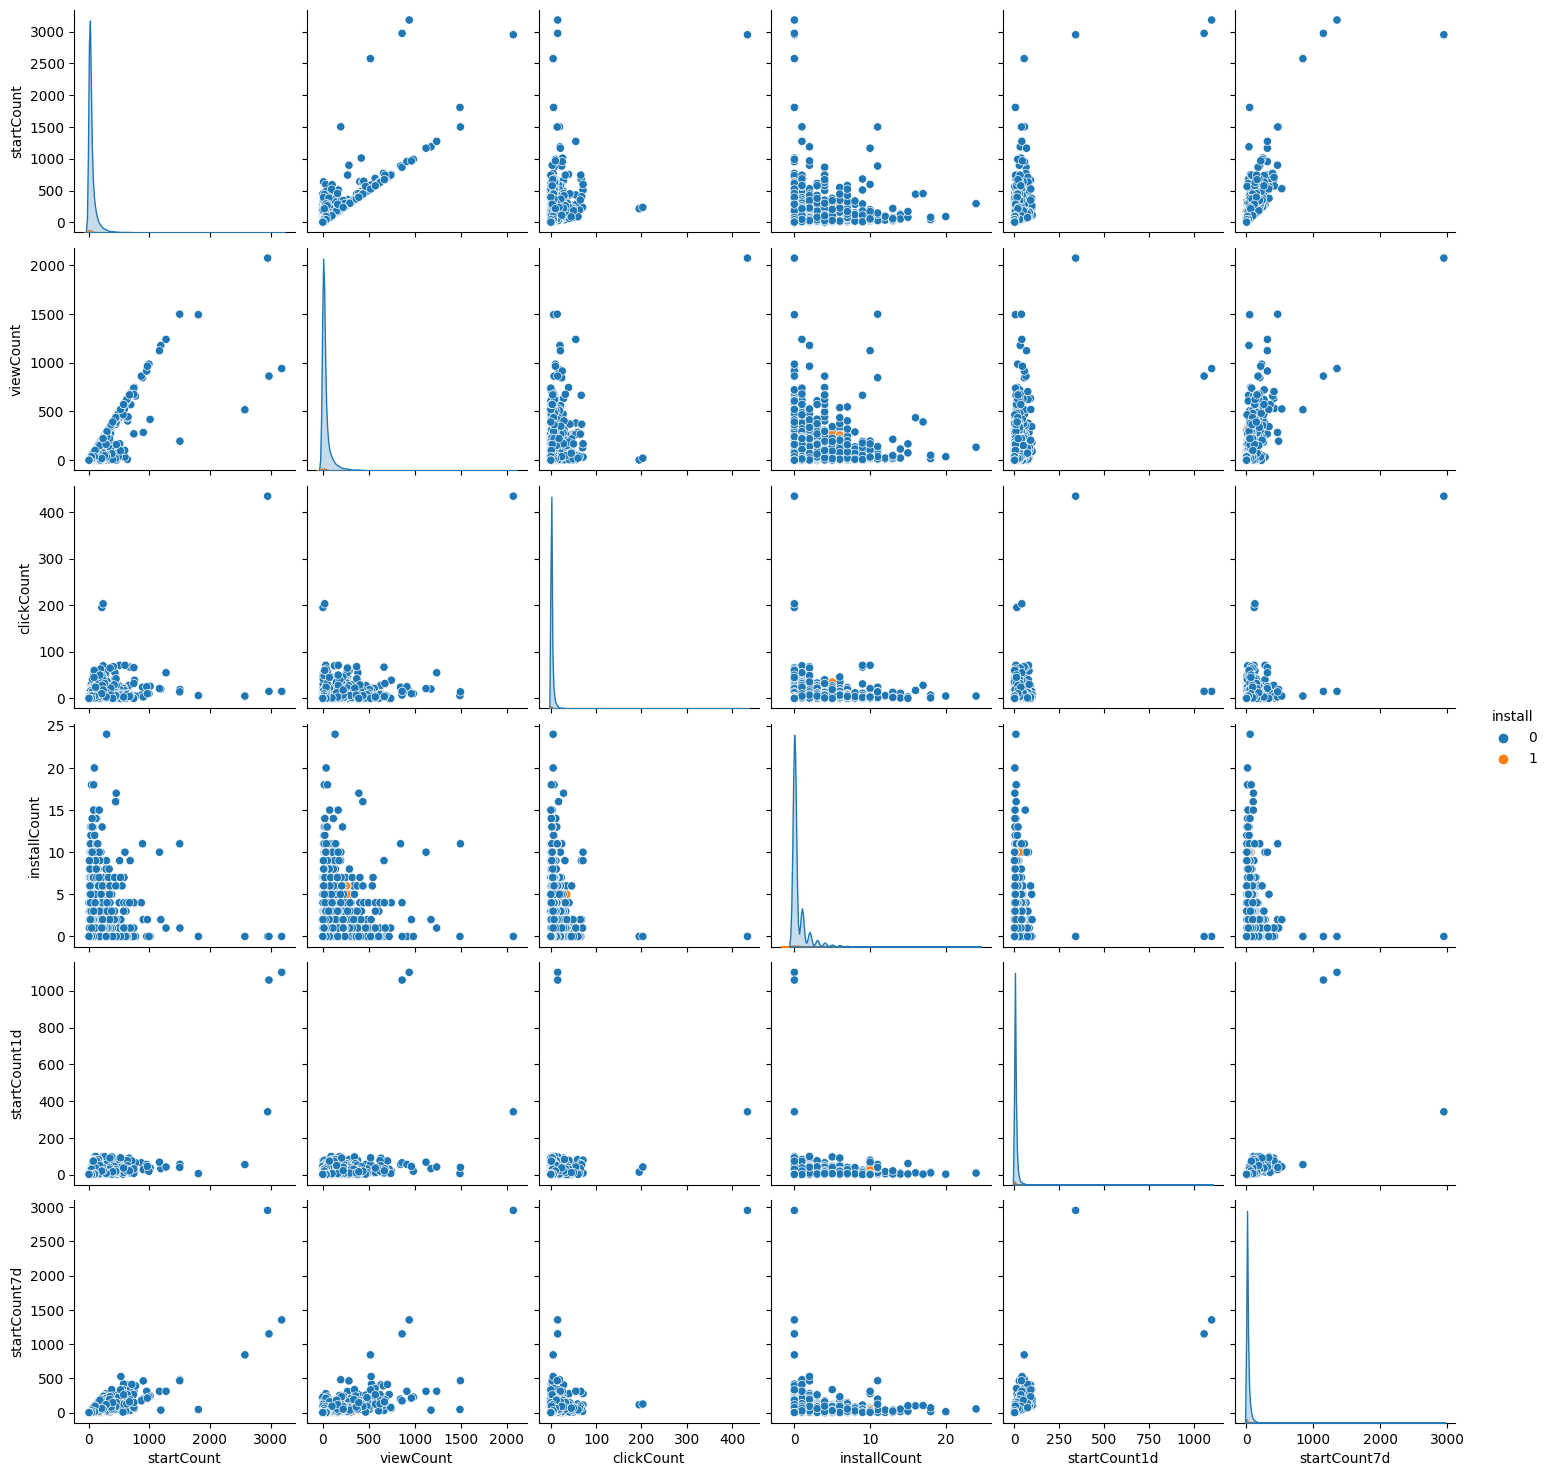

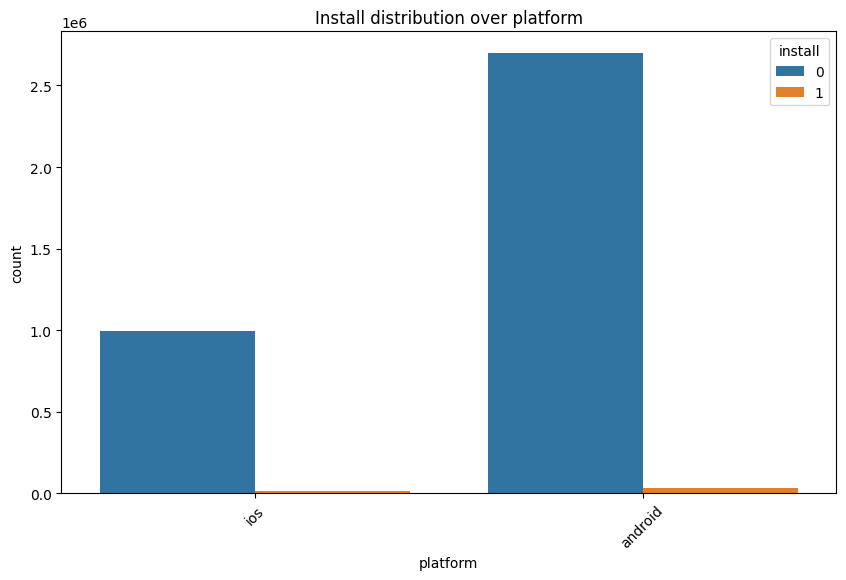

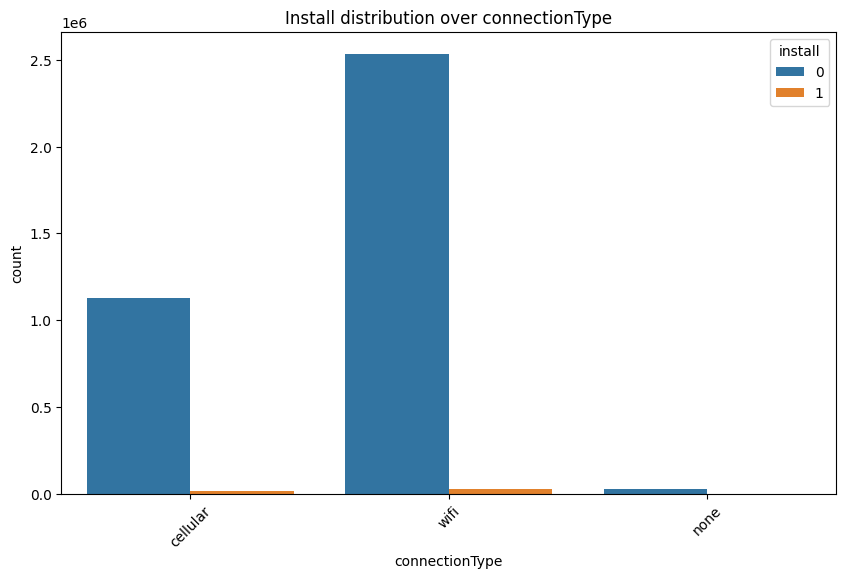

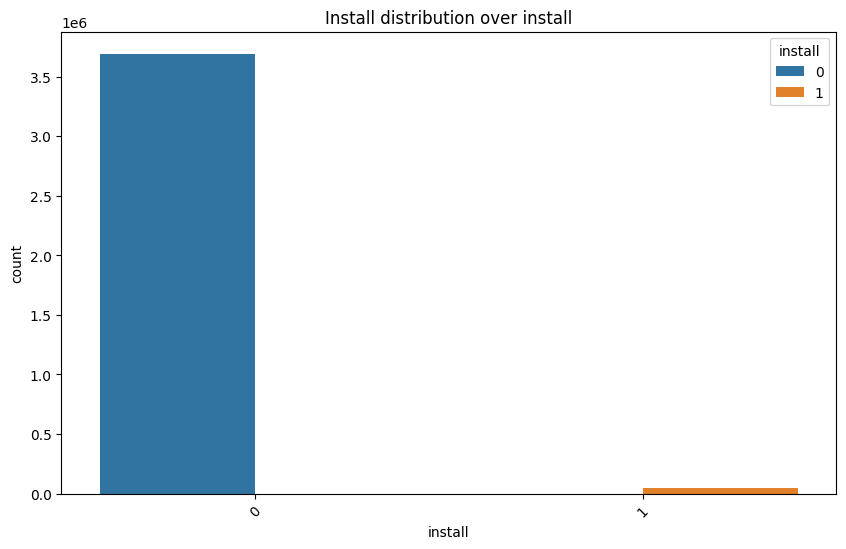

In [12]:
# Bivariate Analysis

# Since the dataset is huge, take 10000 random samples from the dataframe which I am using to plot.
sampled_data = trainDF[numerical_columns].sample(n=10000, random_state=1) if len(trainDF) > 10000 else trainDF[numerical_columns]

# Plotting the pair plot
sns.pairplot(sampled_data , hue='install')
plt.show()

# Relationship between categorical features and target variable 'install'
for col in categorical_columns:
    if trainDF[col].nunique() < 50:  # limiting the data
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, hue='install', data=trainDF)
        plt.title(f'Install distribution over {col}')
        plt.xticks(rotation=45)
        plt.show()


#Feature Engineering and Data pre processing
Step 4: Data Preprocessing
* Handle missing values if any.
* Convert categorical variables into a format that can be provided to a neural  network (If necessary).
* Normalize/Standardize numerical features.

# ID
Since it contains all unique values only and wont have any impact on the install so I will remove it.

In [13]:
# Remove the unique identifier as it's not useful for modeling
trainDF = trainDF.drop(columns="id")


#timestamp and lastStart:
timestamp: time of the event in UTC.
LastStart: the time of users last start event (any campaign)

I am replacing the nan values in 'lastStart' with a dummy value of "1970-01-01" which I will break down in different columns of "hour" ,"weekday".

In [14]:
# convert the string objects to datetime
trainDF['timestamp'] = pd.to_datetime(trainDF['timestamp'],infer_datetime_format=True)
trainDF['lastStart'] = pd.to_datetime(trainDF['lastStart'],infer_datetime_format=True)
trainDF.loc[trainDF['lastStart'] == 0, 'lastStart'] = pd.to_datetime("1970-01-01")


# Extract features from timestamp columns, for example, hour of the day, weekday, etc.
trainDF['hour'] = trainDF['timestamp'].dt.hour
trainDF['weekday'] = trainDF['timestamp'].dt.weekday
trainDF = trainDF.drop(['timestamp', 'lastStart'], axis=1)

####Moving forward, I plan to delve into several time-related features to enhance our understanding of user behavior and engagement:

* Hour of the Day: I aim to analyze how user interaction with our platform varies at different hours, which could be instrumental in pinpointing peak engagement times.
* Day of the Week: I'm interested in investigating the variation in ad interactions across different days of the week, particularly to distinguish between weekday and weekend patterns.
* Time Since Last Start: I plan to explore how the time elapsed since a user's last interaction might affect their likelihood to install, which could inform the timing of re-engagement efforts.
* Local Time Conversion: By converting UTC timestamps to local time using the user's 'country' data, I intend to gain a clearer picture of user behavior within their specific regional context.
* Temporal Trends: I would like to track installation trends over time to identify any correlations with external events or campaign launches, allowing us to adapt more dynamically to market changes.
* Seasonality and Special Events: Recognizing and accounting for special events or seasonal trends is also on my agenda, as this could be key to optimizing campaign strategies around times of heightened user activity.

##campaignId

* The id of the advertising campaign.
I am trying to find frequency of campaign id and had how many respective installations they have.

In [15]:
# Analyze the campaign data - find frequency where install ==1
campaign_counts = trainDF['campaignId'].value_counts()
install_per_campaign = trainDF[trainDF['install'] == 1]['campaignId'].value_counts()

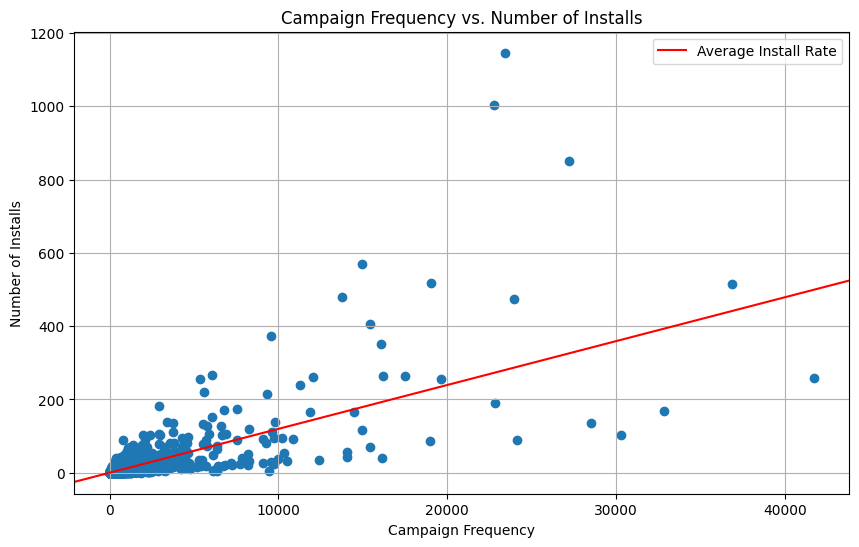

In [16]:
campaign_data = pd.DataFrame({
    'Campaign Frequency': campaign_counts,
    'Number of Installs': install_per_campaign
}).fillna(0)  # Filling NaN with 0 where there are no installs

# Calculate average install rate
average_install_rate = trainDF['install'].mean()

# Plot campaign frequencies against number of installs
plt.figure(figsize=(10, 6))
plt.scatter(campaign_data['Campaign Frequency'], campaign_data['Number of Installs'])
plt.axline((0, 0), slope=average_install_rate, color='red', label='Average Install Rate')

plt.xlabel("Campaign Frequency")
plt.ylabel("Number of Installs")
plt.title("Campaign Frequency vs. Number of Installs")
plt.legend()
plt.grid(True)
plt.show()


 I have prepared a scatter plot that maps out each campaign's frequency against its number of installs. This plot is enhanced with an average install rate line, represented in red, serving as a reference to gauge individual campaign performance against the overall average.

In [17]:
campaign_data.head()

,Campaign Frequency,Number of Installs
54913a686fe1561746000011,141,0.0
54913b2da8cee20d7800001c,286,2.0
550a9a0c163f0b100000000f,71,1.0
573a3d6279129100048b862e,29,0.0
5744346da4bd7f360141d32a,3407,138.0


Observations -

There is a notable spread in the number of installs across campaigns with similar frequencies, suggesting other influencing factors.

A few campaigns are outliers with exceptionally high install numbers.
High-frequency campaigns do not always yield a proportionally high number of installs, suggesting potential diminishing returns.
Campaigns with low frequency exhibit a wide range of install numbers, which could point to the effectiveness of targeting or the novelty of the campaigns.

Things that can be done -


For a more effective campaign recommendation system, we can start by exploring simpler methods. Initially, we could examine the characteristics of the campaigns, including content, design, and targeting strategies, to understand their impact on install rates. Additionally, a closer look at user engagement and interaction patterns with campaigns can offer insights.


In [18]:
# Convert campaignId counts to a dictionary
campaignId_dict = campaign_counts.to_dict()

# Map each campaignId to its frequency and create a new column
trainDF['campaign_freq'] = trainDF['campaignId'].map(campaignId_dict)

# Drop the 'campaignId' column
trainDF = trainDF.drop(columns='campaignId')

#platform

User's platform (two options: android and ios)
I am converting it into a binary classification 1 for iOS and 0 for Android

In [19]:
print(trainDF['platform'].value_counts())

android    2728870
ios        1009893
Name: platform, dtype: int64


In [20]:
# Convert platform to binary values: 1 for iOS and 0 for Android
trainDF['platform'] = (trainDF['platform'] == 'ios').astype(int)

Binary representation in this case is sufficient because there are only two categories and they are mutually exclusive.

#Software-version
Software version of the device.
There are 195 different software versions.
To simplify this feature, we extract the first number in the 'softwareVersion' string and consider it as the representative of the software version. The following code block builds this new feature 'softwareVersion_num' and drops 'softwareVersion' column.

We could drop this also , but it maye impact install hinting latest version of software may have more installs

In [21]:
# Function to extract the first number from the 'softwareVersion' string
def find_first_number(string):
    for i in string.split('.'):
        if i.isdigit():
            return int(i)
    return 0

# Apply the function to the 'softwareVersion' column
trainDF['softwareVersion_num'] = trainDF['softwareVersion'].apply(find_first_number)

# Drop the original 'softwareVersion' column
trainDF.drop('softwareVersion', axis=1, inplace=True)

# Now, to check if the latest software version has more installs:
# First, find the max version number
max_version_num = trainDF['softwareVersion_num'].max()

# Then calculate the install rate for the latest version
latest_version_install_rate = trainDF[trainDF['softwareVersion_num'] == max_version_num]['install'].mean()

# And compare it to the overall install rate
overall_install_rate = trainDF['install'].mean()

# Output the comparison
print(f"Install rate for the latest version ({max_version_num}): {latest_version_install_rate}")
print(f"Overall install rate: {overall_install_rate}")

# Optionally, output whether the latest version has a higher install rate
if latest_version_install_rate > overall_install_rate:
    print(f"The latest version of the software has a higher install rate than the average.")
else:
    print(f"The latest version of the software does not have a higher install rate than the average.")

Install rate for the latest version (901): 0.0
Overall install rate: 0.011967594629560633
The latest version of the software does not have a higher install rate than the average.


#sourceGameId

Similar to CampaignId -  I am calculating frequency of SourceGame id and how many respective installations they have.

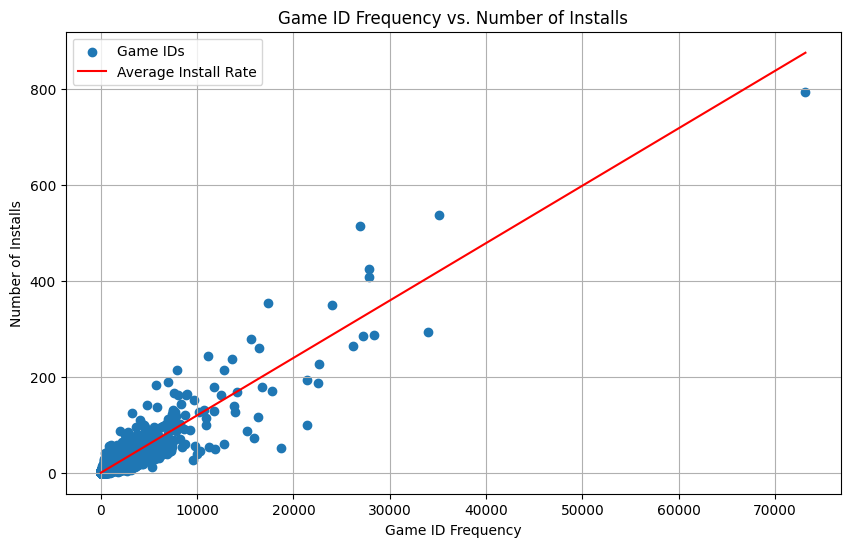

In [22]:
# Compute sourceGameId frequencies
gameId_counts = trainDF['sourceGameId'].value_counts()

# Find the number of installs for each gameId
install_1_frame = trainDF[trainDF['install'] == 1]
install_per_gameId = {game_id: (install_1_frame['sourceGameId'] == game_id).sum() for game_id in gameId_counts.index}

# Plot gameId frequencies against number of installs
plt.figure(figsize=(10, 6))
plt.scatter(gameId_counts.values, [install_per_gameId[game_id] for game_id in gameId_counts.index], label='Game IDs')

# Calculate the average install rate
average_install_rate = trainDF['install'].mean()
max_gameId_count = max(gameId_counts)

# Draw a line representing the average install rate
plt.plot([0, max_gameId_count], [0, max_gameId_count * average_install_rate], 'r-', label='Average Install Rate')

plt.legend()
plt.title("Game ID Frequency vs. Number of Installs")
plt.xlabel("Game ID Frequency")
plt.ylabel("Number of Installs")
plt.grid(True)
plt.show()

# Mapping gameId frequency to the dataset
trainDF['gameId_freq'] = trainDF['sourceGameId'].map(gameId_counts)
trainDF.drop('sourceGameId', axis=1, inplace=True)


The scatter plot analysis indicates that games with more frequent ad campaigns usually have more installs. However, this trend isn't always consistent, with some games being outliers. This implies that there's more to the story than just ad frequency. In future work, examining game types, user reviews, and marketing efforts may provide better insight. Additionally, looking into how users engage with a game after installing could reveal more about what keeps players coming back. Considering how time of year affects game popularity might also give us valuable context for these trends.

#Country


*   296 null values
*   This column has some potential but at present I am engineering a new feature - "country_ratio" with values as country install ratios.




Missing country data: 296


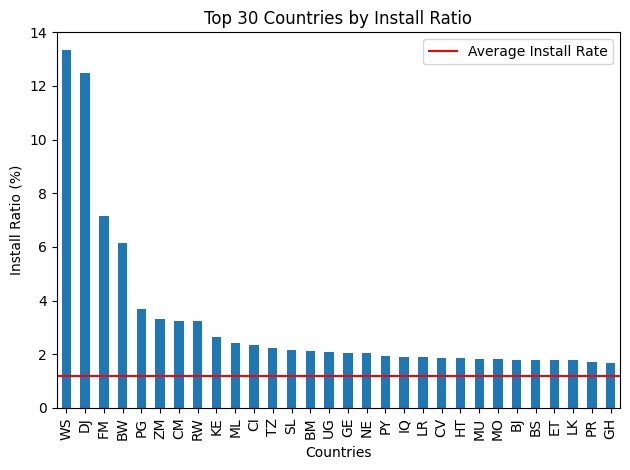

In [23]:
# Check and remove rows with missing country information
print(f"Missing country data: {trainDF['country'].isnull().sum()}")
trainDF.dropna(subset=['country'], inplace=True)
trainDF.reset_index(drop=True, inplace=True)

# Calculate country install ratios
country_install_counts = trainDF.groupby('country')['install'].sum()
country_user_counts = trainDF['country'].value_counts()
country_install_ratio = (country_install_counts / country_user_counts).fillna(0)

# Visualize the install ratio for the top countries
top_countries = country_install_ratio.nlargest(30) * 100
top_countries.plot(kind='bar')
plt.axhline(y=trainDF['install'].mean() * 100, color='r', linestyle='-', label='Average Install Rate')
plt.title("Top 30 Countries by Install Ratio")
plt.xlabel("Countries")
plt.ylabel("Install Ratio (%)")
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Incorporate the install ratio into the main dataset
trainDF['country_ratio'] = trainDF['country'].map(country_install_ratio)
trainDF.drop(columns=['country'], inplace=True)


 The code calculates each country's install ratio by comparing the sum of installs to the total user count.

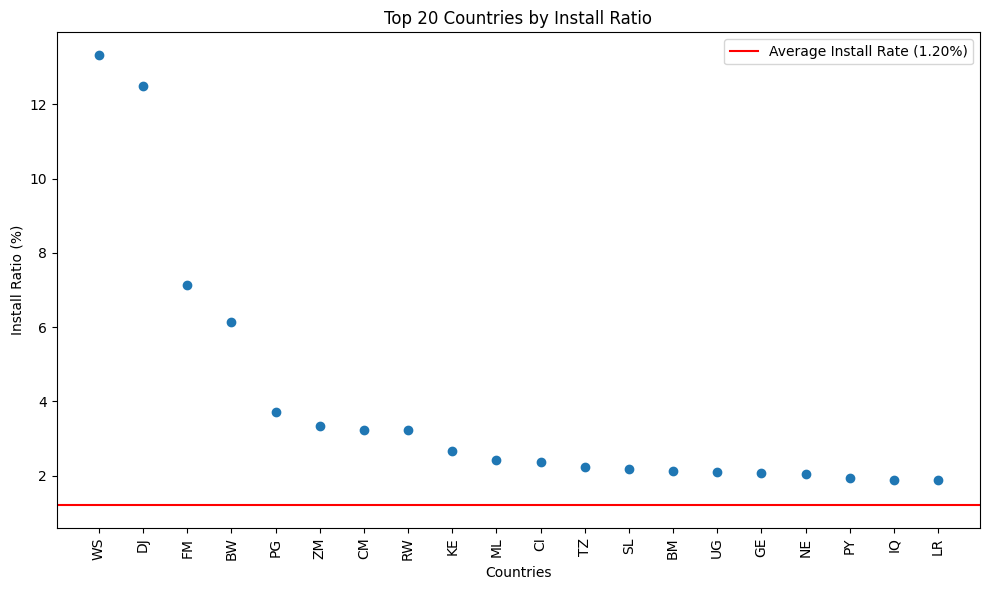

In [24]:
# Sort the ratios and take the top 20
top_countries = country_install_ratio.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.scatter(top_countries.index, top_countries.values * 100)

# Average install rate line
average_install_rate = trainDF['install'].mean() * 100
plt.axhline(y=average_install_rate, color='r', linestyle='-', label=f'Average Install Rate ({average_install_rate:.2f}%)')

plt.title("Top 20 Countries by Install Ratio")
plt.xlabel("Countries")
plt.ylabel("Install Ratio (%)")
plt.legend()
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.tight_layout()  # Adjust layout to fit all labels
plt.show()


Observations:

The install ratio varies significantly across different countries, with some countries having a significantly higher ratio than others.
The country with the highest install ratio, represented by the leftmost point on the graph, has a ratio of more than 12%, which is substantially above the average install rate of 1.20%.
The majority of the top 20 countries have an install ratio between approximately 2% and 4%, suggesting a common range of ratios for countries that are not outliers.

### *startCount*, *viewCount*, *clickCount*, *installCount*, *startCount1d*, and *startCount7d* :
* **startCount**: how many times the user has ever started a campaign ever
* **viewCount**: how many times the user has ever viewed a campaign ever
* **clickCount**: how many times the user has ever clicked a campaign ever
* **installCount**: how many times the user has installed games from this network ever
* **startCount1d**: how many times user has started (any) campaigns within the last 24h
* **startCount7d**: how many times user has started (any) campaigns within the last 7 days


The graph of the dependency is already shown above


# ConnectionType :
* Internet connection type (three types: wifi, cellular, none)
* The following code block creates two new features ('wifi' and 'cellular') and removes 'connectionType'.

In [25]:
print(trainDF['connectionType'].value_counts()) #each type of internet connection
trainDF['wifi'] = (trainDF['connectionType'] == 'wifi').astype(int) #1 if wifi, 0 otherwise

trainDF['cellular'] = (trainDF['connectionType'] == 'cellular').astype(int) #1 if cellular, 0 otherwise

# Remove the original 'connectionType' column
trainDF.drop(columns=['connectionType'], inplace=True)


wifi        2564248
cellular    1144243
none          29976
Name: connectionType, dtype: int64


#  deviceType:
* Device model (total of 28297 models)

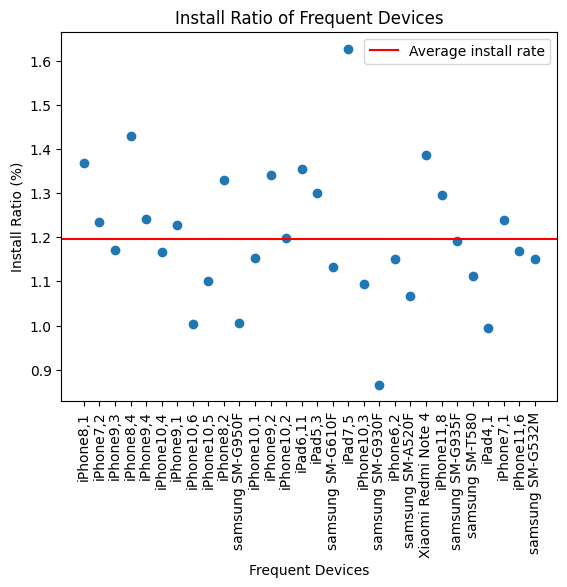

In [26]:
# Compute device frequencies
device_counts = trainDF['deviceType'].value_counts()

# Find the number of installs for each device
# Create and Use a mask for rows where an install occurred
install_mask = trainDF['install'] == 1
install_1_frame = trainDF[install_mask]
install_per_device = np.zeros(len(device_counts))

# Iterate over each device type and count the number of installs
for idx, device_type in enumerate(device_counts.index):
    install_per_device[idx] = install_1_frame[install_1_frame['deviceType'] == device_type].shape[0]

# Calculate the install ratio for each device type
install_per_device_ratio = install_per_device / device_counts.values

# Visualize the install ratio for the most popular device types
plt.scatter(range(len(device_counts[:30])), install_per_device_ratio[:30] * 100)
plt.axhline(y=(100 * trainDF['install'].mean()), color='r', linestyle='-', label='Average install rate')
plt.title("Install Ratio of Frequent Devices")
plt.xticks(ticks=range(len(device_counts[:30])), labels=device_counts.index[:30], rotation=90)
plt.xlabel("Frequent Devices")
plt.ylabel("Install Ratio (%)")
plt.legend()
plt.show()


Several devices demonstrate a notably higher install ratio compared to the average, suggesting they may be more popular or better suited for the application in question.

A majority of the devices show install ratios close to the average, indicating a consistent performance across various devices for app installation likelihood.

Some devices show an install ratio that is below the average, which could imply lower user engagement or compatibility issues with the application on those devices.

In [27]:
# remove 'deviceType' column we can consider it in future
trainDF = trainDF.drop(columns="deviceType")

Now storing my processed data frame.

In [28]:
trainDF.to_csv(r'/content/drive/MyDrive/Colab Notebooks/trainDF_new.csv', index = None)

In [29]:
trainDF.columns

Index(['platform', 'startCount', 'viewCount', 'clickCount', 'installCount',
       'startCount1d', 'startCount7d', 'install', 'hour', 'weekday',
       'campaign_freq', 'softwareVersion_num', 'gameId_freq', 'country_ratio',
       'wifi', 'cellular'],
      dtype='object')

The following code box reads the modified training data from the CSV file and removes the "index" and label ("install") columns from the data.

# Step 5: Model Development and Step 6: Model Evaluation
###( Data standardization and balancing)
* Define a neural network architecture using TensorFlow, PyTorch, or a similar framework.
* Train the model on the training data using an appropriate optimizer and loss function for a binary classification problem.
* Validate the model using the validation set to avoid overfitting.
* Evaluate the model using ROC AUC, log loss, and prediction bias.
* Possibly use additional metrics for a more thorough evaluation.
* Use the validation set for evaluation and adjust the model if necessary.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, confusion_matrix, classification_report, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools

In [31]:
# Load the modified training data
tr_filename = '/content/drive/MyDrive/Colab Notebooks/trainDF_new.csv'
tr_data_m = pd.read_csv(tr_filename)

Y = tr_data_m['install']
tr_data_m = tr_data_m.drop(columns="install")
# Print some basic statistics
print(tr_data_m.info())
print("number of data in class 1: {}".format(sum(Y==1)))
print("number of data in class 0: {}".format(sum(Y==0)))
#tr_data_m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738467 entries, 0 to 3738466
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   platform             int64  
 1   startCount           int64  
 2   viewCount            int64  
 3   clickCount           int64  
 4   installCount         int64  
 5   startCount1d         int64  
 6   startCount7d         int64  
 7   hour                 int64  
 8   weekday              int64  
 9   campaign_freq        int64  
 10  softwareVersion_num  int64  
 11  gameId_freq          int64  
 12  country_ratio        float64
 13  wifi                 int64  
 14  cellular             int64  
dtypes: float64(1), int64(14)
memory usage: 427.8 MB
None
number of data in class 1: 44738
number of data in class 0: 3693729


In [32]:
tr_data_m.drop(columns =["country_ratio"],inplace=True) #dropping right now , will consider in future

In [33]:
tr_data_m[:10]

,platform,startCount,viewCount,clickCount,installCount,startCount1d,startCount7d,hour,weekday,campaign_freq,softwareVersion_num,gameId_freq,wifi,cellular
0,1,25,24,0,2,1,8,21,2,58,11,724,0,1
1,1,10,9,2,0,1,4,17,4,58,12,324,0,1
2,1,27,26,0,0,1,2,11,4,58,12,724,0,1
3,1,15,14,2,0,3,14,15,3,58,12,157,1,0
4,1,20,18,0,0,13,18,21,4,58,12,724,0,1
5,1,26,4,1,0,7,20,19,5,58,12,5478,1,0
6,1,38,35,0,0,9,34,2,1,58,12,724,1,0
7,1,53,52,1,0,2,53,1,1,58,12,724,1,0
8,1,114,110,0,0,5,11,21,4,58,12,10022,1,0
9,1,47,46,0,0,2,17,4,4,58,11,10022,0,1


In [34]:
# Standardization of numerical columns
numerical_cols = ['startCount', 'viewCount', 'clickCount', 'installCount', 'startCount1d', 'startCount7d', 'campaign_freq', 'gameId_freq']
scaler = StandardScaler()
tr_data_m[numerical_cols] = scaler.fit_transform(tr_data_m[numerical_cols])

# Split the data into train and validation sets
X=tr_data_m
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [35]:
tr_data_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738467 entries, 0 to 3738466
Data columns (total 14 columns):
 #   Column               Dtype  
---  ------               -----  
 0   platform             int64  
 1   startCount           float64
 2   viewCount            float64
 3   clickCount           float64
 4   installCount         float64
 5   startCount1d         float64
 6   startCount7d         float64
 7   hour                 int64  
 8   weekday              int64  
 9   campaign_freq        float64
 10  softwareVersion_num  int64  
 11  gameId_freq          float64
 12  wifi                 int64  
 13  cellular             int64  
dtypes: float64(8), int64(6)
memory usage: 399.3 MB


In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2990773 entries, 2761712 to 2219110
Data columns (total 14 columns):
 #   Column               Dtype  
---  ------               -----  
 0   platform             int64  
 1   startCount           float64
 2   viewCount            float64
 3   clickCount           float64
 4   installCount         float64
 5   startCount1d         float64
 6   startCount7d         float64
 7   hour                 int64  
 8   weekday              int64  
 9   campaign_freq        float64
 10  softwareVersion_num  int64  
 11  gameId_freq          float64
 12  wifi                 int64  
 13  cellular             int64  
dtypes: float64(8), int64(6)
memory usage: 342.3 MB


#Trying H2O
* It did not work properly due to bulky dataset, I will try it later

In [37]:
'''import h2o
from h2o.automl import H2OAutoML
response_col = 'install'
# Initialize the H2O cluster
h2o.init(max_mem_size='16G')


h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
h2o_val = h2o.H2OFrame(pd.concat([X_val, y_val], axis=1))
h2o_train[response_col] = h2o_train[response_col].asfactor() # check this
# Define response and predictor variables

predictors = h2o_train.columns[:-1]  # all columns except 'install'

# Define the AutoML model
aml = H2OAutoML(max_models=10,
                seed=42,
                project_name='install_pred_project',
                include_algos=["GLM", "DRF", "GBM"],  # GLM for logistic, DRF for random forest, XRT for extremely randomized trees
                balance_classes=True)  # Balance classes automatically

# Train the AutoML model
aml.train(x=predictors, y=response_col, training_frame=h2o_train)

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb)


model_ids = list(lb['model_id'].as_data_frame().iloc[:,0])
glm_models = [m for m in model_ids if "GLM" in m]
drf_models = [m for m in model_ids if "DRF" in m]
xg_models = [m for m in model_ids if "XGBoost" in m]
# Get the best GLM and DRF models based on the leaderboard ranking
best_glm_model = h2o.get_model(glm_models[0])
best_drf_model = h2o.get_model(drf_models[0])
best_xg_model = h2o.get_model(xg_models[0])
# Evaluate model performance using ROC AUC, log loss, and prediction bias
perf_glm = best_glm_model.model_performance(hf)
perf_drf = best_drf_model.model_performance(hf)
perf_xg = best_xg_model.model_performance(hf)

print(f"GLM AUC: {perf_glm.auc()}")
print(f"GLM Log Loss: {perf_glm.logloss()}")

print(f"DRF AUC: {perf_drf.auc()}")
print(f"DRF Log Loss: {perf_drf.logloss()}")

print(f"XGBoost AUC: {perf_xg.auc()}")
print(f"XGBoost Log Loss: {perf_xg.logloss()}")

# Predict on the validation set
hf_val = h2o.H2OFrame(X_val)
glm_preds_val = best_glm_model.predict(hf_val)['p1'].as_data_frame()
drf_preds_val = best_drf_model.predict(hf_val)['p1'].as_data_frame()
xg_preds_val = best_xg_model.predict(hf_val)['p1'].as_data_frame()
# Calculate prediction bias
glm_bias = glm_preds_val.mean()[0] - y_val.mean()
drf_bias = drf_preds_val.mean()[0] - y_val.mean()
xg_bias = xg_preds_val.mean()[0] - y_val.mean()

print(f"GLM Prediction Bias: {glm_bias}")
print(f"DRF Prediction Bias: {drf_bias}")
print(f"XGBoost Prediction Bias: {xg_bias}")'''

'import h2o\nfrom h2o.automl import H2OAutoML\nresponse_col = \'install\'\n# Initialize the H2O cluster\nh2o.init(max_mem_size=\'16G\')\n\n# Assume \'X\' and \'Y\' are your features and labels after preprocessing and they are pandas DataFrames or Series\nh2o_train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))\nh2o_val = h2o.H2OFrame(pd.concat([X_val, y_val], axis=1))\nh2o_train[response_col] = h2o_train[response_col].asfactor() # check this\n# Define response and predictor variables\n\npredictors = h2o_train.columns[:-1]  # all columns except \'install\'\n\n# Define the AutoML model\naml = H2OAutoML(max_models=10,\n                seed=42,\n                project_name=\'install_pred_project\',\n                include_algos=["GLM", "DRF", "GBM"],  # GLM for logistic, DRF for random forest, XRT for extremely randomized trees\n                balance_classes=True)  # Balance classes automatically\n\n# Train the AutoML model\naml.train(x=predictors, y=response_col, training_frame

## Handling imbalanced dataset

In [38]:
# Handling oversample with SMOTE and undersample with RandomUnderSampler
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

# The pipeline first oversamples the minority class to have 10% of the majority class's size,then undersamples the majority class to have twice the size of the oversampled minority class
pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Check the balance of the resampled data
print("After resampling:")
print("Class 1: {}".format(sum(y_train_resampled == 1)))
print("Class 0: {}".format(sum(y_train_resampled == 0)))


After resampling:
Class 1: 295498
Class 0: 590996


In [39]:
#Plot Confusion Matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0, 1])
    plt.yticks(tick_marks, [0, 1])

    # Labeling the plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


## Model 1 -Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression ROC AUC: 0.6383722610306386
Logistic Regression log loss: 0.40020615449442964
Logistic Regression prediction bias: 0.30342919558130005


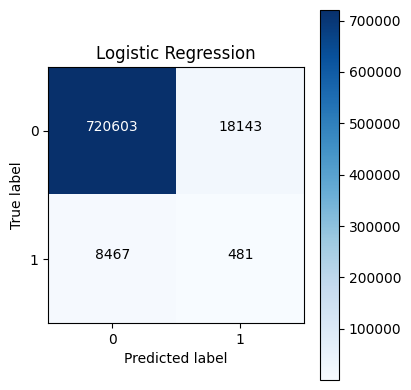

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    738746
           1       0.03      0.05      0.03      8948

    accuracy                           0.96    747694
   macro avg       0.51      0.51      0.51    747694
weighted avg       0.98      0.96      0.97    747694



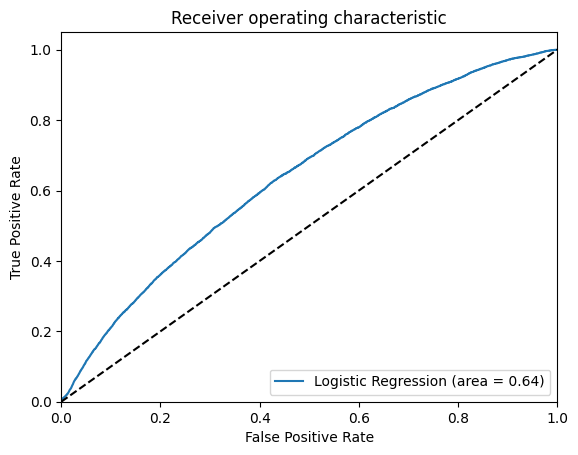

In [40]:
# Train the model
lr = LogisticRegression(random_state=42)
lr.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_val_pred = lr.predict(X_val)
y_val_pred_proba = lr.predict_proba(X_val)[:, 1]

# Calculate and print the evaluation metrics
print("Logistic Regression ROC AUC:", roc_auc_score(y_val, y_val_pred_proba))
print("Logistic Regression log loss:", log_loss(y_val, y_val_pred_proba))
print("Logistic Regression prediction bias:", y_val_pred_proba.mean() - y_val.mean())

# Calculate confusion matrix
confusion_matrix_logreg = confusion_matrix(y_val, y_val_pred)

# Calculate log loss
log_loss_logreg = log_loss(y_val, y_val_pred_proba)

# Calculate prediction bias
prediction_bias_logreg = y_val_pred_proba.mean() - y_val.mean()

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(confusion_matrix_logreg, title='Logistic Regression')

# Classification report
print(classification_report(y_val, y_val_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_val, y_val_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


##Observations -
* ROC AUC: A value of 0.64 is better than a random guess (which would be 0.5), but it's not very high. This suggests that the model has moderate discrimination capacity between the positive and negative classes.

* Log Loss: A value of 0.397 indicates the confidence of the probability predictions. The lower the log loss, the better the model.

* Prediction Bias: The prediction bias of 0.3 suggests that the model is more inclined to predict an instance as class 1 (install) than the actual distribution suggests. This could be a result of the resampling techniques used to handle the imbalanced dataset.

####To improve the performance, consider the following steps:

* Feature Engineering: More features might improve the model's predictive power, or some existing features could be transformed for better representation.

* Alternative Resampling: Adjust the resampling strategy or class weights to find a better balance between precision and recall for the minority class


# Model 2 -Decision Tree Model

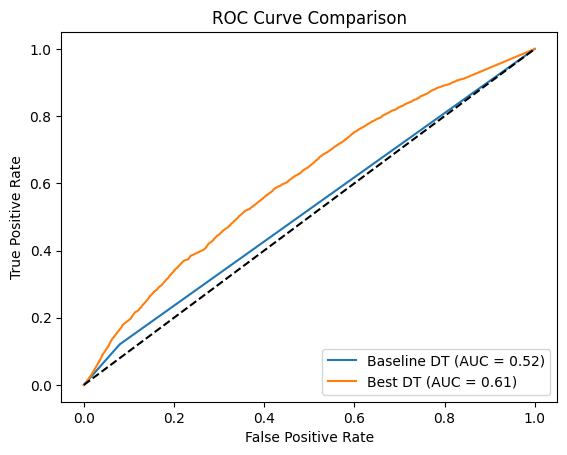

Improvement in ROC AUC: 0.0908


In [41]:
# Step 1: Train the baseline Decision Tree model
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_resampled, y_train_resampled)
y_val_pred_proba_baseline = dt_baseline.predict_proba(X_val)[:, 1]
roc_auc_baseline = roc_auc_score(y_val, y_val_pred_proba_baseline)

# Plot ROC curve for the baseline model
fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_val_pred_proba_baseline)
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline DT (AUC = {roc_auc_baseline:.2f})')

# Step 2: Perform grid search to find better hyperparameters
param_grid = {'max_depth': range(1, 20)}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

# Step 3: Train the new Decision Tree model with the best parameters found
dt_best = DecisionTreeClassifier(random_state=42, **grid_search.best_params_)
dt_best.fit(X_train_resampled, y_train_resampled)
y_val_pred_proba_best = dt_best.predict_proba(X_val)[:, 1]
roc_auc_best = roc_auc_score(y_val, y_val_pred_proba_best)

# Plot ROC curve for the best model
fpr_best, tpr_best, _ = roc_curve(y_val, y_val_pred_proba_best)
plt.plot(fpr_best, tpr_best, label=f'Best DT (AUC = {roc_auc_best:.2f})')

# Step 4: Compare the ROC AUC score of both models
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# Print the improvement
print(f"Improvement in ROC AUC: {roc_auc_best - roc_auc_baseline:.4f}")


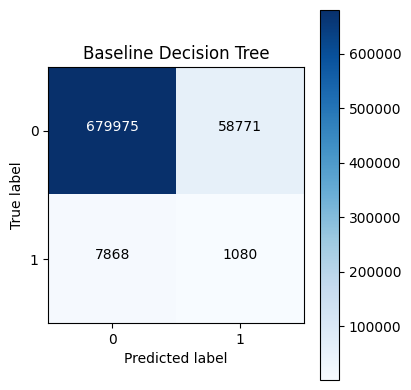

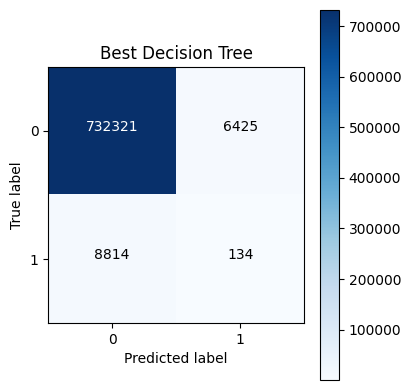

Baseline Decision Tree Log Loss: 3.2124
Best Decision Tree Log Loss: 0.3727
Baseline Decision Tree Prediction Bias: 0.0681
Best Decision Tree Prediction Bias: 0.0840


In [42]:
# Calculate predictions for baseline and best models
y_val_pred_baseline = dt_baseline.predict(X_val)
y_val_pred_best = dt_best.predict(X_val)

# Calculate confusion matrices
confusion_matrix_baseline = confusion_matrix(y_val, y_val_pred_baseline)
confusion_matrix_best = confusion_matrix(y_val, y_val_pred_best)

# Calculate log loss for both models
log_loss_baseline = log_loss(y_val, y_val_pred_proba_baseline)
log_loss_best = log_loss(y_val, y_val_pred_proba_best)

# Calculate and print prediction bias for both models
prediction_bias_baseline = y_val_pred_proba_baseline.mean() - y_val.mean()
prediction_bias_best = y_val_pred_proba_best.mean() - y_val.mean()

# Plot confusion matrices
plot_confusion_matrix(confusion_matrix_baseline, title='Baseline Decision Tree')
plot_confusion_matrix(confusion_matrix_best, title='Best Decision Tree')

# Print log loss and prediction bias
print(f"Baseline Decision Tree Log Loss: {log_loss_baseline:.4f}")
print(f"Best Decision Tree Log Loss: {log_loss_best:.4f}")
print(f"Baseline Decision Tree Prediction Bias: {prediction_bias_baseline:.4f}")
print(f"Best Decision Tree Prediction Bias: {prediction_bias_best:.4f}")


###Observations -

The first model is a baseline with default parameters, while the second model is optimized through grid search to find the best hyperparameters. The ROC curve plot indicates that the optimized model (Best DT) has an improved AUC score of 0.61 compared to the baseline's AUC score of 0.52, demonstrating better discriminative ability between the classes. The dashed line represents a no-skill classifier, and the fact that both models' curves are above this line indicates that they have skill. The grid search enhancement led to a noticeable improvement in model performance, as quantified by the increase in the ROC AUC score.

# Model 3 - Random forest

In [45]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best hyperparameters and best score
print("Best hyperparameters found by grid search:", grid_search_rf.best_params_)
print("Best ROC AUC score found by grid search:", grid_search_rf.best_score_)

# Train a new classifier using the best parameters found
rf_best = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
rf_best.fit(X_train_resampled, y_train_resampled)
y_val_pred_proba_rf = rf_best.predict_proba(X_val)[:, 1]
y_val_pred_rf = rf_best.predict(X_val)

# Calculate and print the evaluation metrics
print("Random Forest ROC AUC:", roc_auc_score(y_val, y_val_pred_proba_rf))
print("Random Forest log loss:", log_loss(y_val, y_val_pred_proba_rf))
print("Random Forest prediction bias:", y_val_pred_proba_rf.mean() - y_val.mean())

Best hyperparameters found by grid search: {'max_depth': 15, 'n_estimators': 200}
Best ROC AUC score found by grid search: 0.9400865378003251
Random Forest ROC AUC: 0.6547276340777705
Random Forest log loss: 0.2056351231999403
Random Forest prediction bias: 0.15481801910746712


In [46]:
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_val, y_val_pred_rf)
print("Confusion Matrix:\n", conf_matrix_rf)

# Classification report
print(classification_report(y_val, y_val_pred_rf))

Confusion Matrix:
 [[736845   1901]
 [  8858     90]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    738746
           1       0.05      0.01      0.02      8948

    accuracy                           0.99    747694
   macro avg       0.52      0.50      0.50    747694
weighted avg       0.98      0.99      0.98    747694



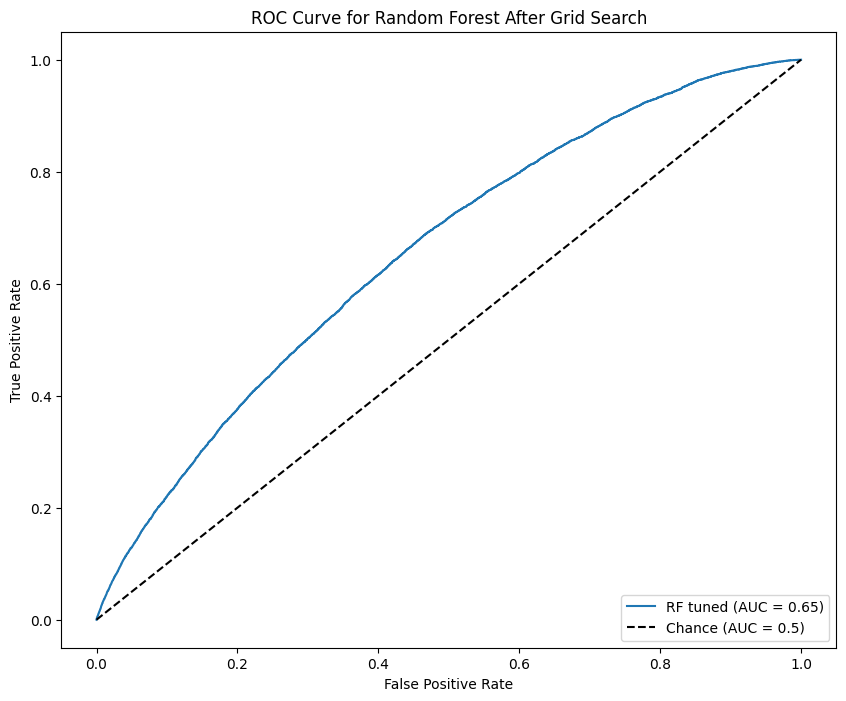

In [47]:
# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_pred_proba_rf)
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'RF tuned (AUC = {roc_auc_score(y_val, y_val_pred_proba_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest After Grid Search')
plt.legend(loc='lower right')
plt.show()

###Observations -

The best parameters are not giving good results , I can try other methods for hyper parameter tuning.

# Method 4 -Neural Network

In [48]:
!pip install tensorflow
!pip install imbalanced-learn

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import math
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, log_loss
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2

### A failed neural network model

In [50]:
'''from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
import math
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, log_loss
import matplotlib.pyplot as plt

# Define class weights due to imbalance in the dataset
class_weights = {
    0: (1 / sum(y_train_resampled == 0)) * (len(y_train_resampled) / 2.0),
    1: (1 / sum(y_train_resampled == 1)) * (len(y_train_resampled) / 2.0),
}

# Define a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Neural network architecture with L2 regularization
model = Sequential()
model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['AUC', 'Precision', 'Recall'])

# Callbacks
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('/content/drive/MyDrive/models/best_model1.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True)

# Train the model with the learning rate scheduler in the callbacks
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[es, mc, lr_scheduler],
    verbose=1
)

# Save the latest model as well (in case the best model checkpoint is not the latest)
model.save('/content/drive/MyDrive/sig_latest_model_new.h5')
'''

"from tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Dropout\nfrom tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint\nfrom tensorflow.keras.optimizers import Adam\nfrom tensorflow.keras.callbacks import LearningRateScheduler\nfrom tensorflow.keras.regularizers import l2\nimport math\nimport numpy as np\nfrom sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, log_loss\nimport matplotlib.pyplot as plt\n\n# Define class weights due to imbalance in the dataset\nclass_weights = {\n    0: (1 / sum(y_train_resampled == 0)) * (len(y_train_resampled) / 2.0),\n    1: (1 / sum(y_train_resampled == 1)) * (len(y_train_resampled) / 2.0),\n}\n\n# Define a learning rate scheduler\ndef scheduler(epoch, lr):\n    if epoch < 10:\n        return lr\n    else:\n        return lr * math.exp(-0.1)\n\nlr_scheduler = LearningRateScheduler(scheduler)\n\n# Neural network architecture with L2 regularization\nmodel = Seque

In [51]:
# Define class weights due to imbalance in the dataset
class_weights = {
    0: (1 / sum(y_train_resampled == 0)) * (len(y_train_resampled) / 2.0),
    1: (1 / sum(y_train_resampled == 1)) * (len(y_train_resampled) / 2.0),
}

model = Sequential()
model.add(Dense(3000, input_dim=X_train_resampled.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1600, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(800, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['AUC', 'Precision', 'Recall'])


es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=20)
#mc = ModelCheckpoint('best_model1.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True)

# Train the model
history = model.fit(
    X_train_resampled,
    y_train_resampled,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=500,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)
model.save('/content/drive/MyDrive/sig_latest_model.h5')


Epoch 1/30
1773/1773 [==============================] - 25s 11ms/step - loss: 3.1418 - auc: 0.6153 - precision: 0.3993 - recall: 0.6659 - val_loss: 0.6747 - val_auc: 0.6400 - val_precision: 0.0165 - val_recall: 0.7040
Epoch 2/30
1773/1773 [==============================] - 19s 11ms/step - loss: 0.6782 - auc: 0.6392 - precision: 0.4130 - recall: 0.7080 - val_loss: 0.6492 - val_auc: 0.6422 - val_precision: 0.0174 - val_recall: 0.6245
Epoch 3/30
1773/1773 [==============================] - 19s 11ms/step - loss: 0.6722 - auc: 0.6472 - precision: 0.4175 - recall: 0.7179 - val_loss: 0.6469 - val_auc: 0.6474 - val_precision: 0.0174 - val_recall: 0.6558
Epoch 4/30
1773/1773 [==============================] - 19s 11ms/step - loss: 0.6692 - auc: 0.6509 - precision: 0.4200 - recall: 0.7163 - val_loss: 0.6701 - val_auc: 0.6481 - val_precision: 0.0167 - val_recall: 0.7121
Epoch 5/30
1773/1773 [==============================] - 19s 11ms/step - loss: 0.6672 - auc: 0.6532 - precision: 0.4221 - recall:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23366/23366 [==============================] - 35s 1ms/step
Confusion Matrix:
[[442102 296644]
 [  3210   5738]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75    738746
           1       0.02      0.64      0.04      8948

    accuracy                           0.60    747694
   macro avg       0.51      0.62      0.39    747694
weighted avg       0.98      0.60      0.74    747694

ROC AUC Score: 0.6661038396221413
Prediction Log Loss: 0.6091370341644319


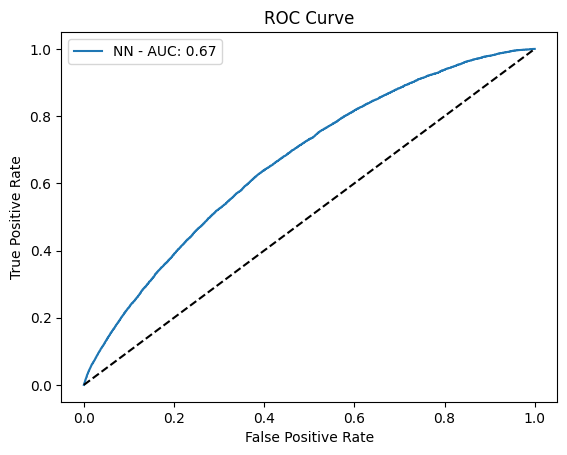

In [52]:
# Load the saved model
saved_model = load_model('/content/drive/MyDrive/sig_latest_model.h5')

# Predictions on the validation set
y_pred_proba = saved_model.predict(X_val).flatten()  # Get probabilities for the positive class

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, np.round(y_pred_proba))
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
cls_report = classification_report(y_val, np.round(y_pred_proba))
print("Classification Report:")
print(cls_report)

# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

# Log Loss
pred_loss = log_loss(y_val, y_pred_proba)
print(f"Prediction Log Loss: {pred_loss}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.plot(fpr, tpr, label=f"NN - AUC: {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


####The model's performance as shown by the confusion matrix indicates that while it has a high precision for the majority class (class 0), it performs poorly on the minority class (class 1), which is a common challenge in imbalanced datasets. The AUC score is moderate, indicating that the model has a fair ability to distinguish between the two classes.

#### If I had more time, I would try to remove biasing in a better way and also Fine-tune hyperparameters methodically, possibly with the help of automated tools and Experiment with different oversampling techniques and ratios.

##Method -

I loaded my training data and preprocessed it by standardizing numerical features and dropping less relevant columns. To tackle the challenge of class imbalance, I used SMOTE and RandomUnderSampler in a pipeline to achieve a better balance between the classes.

In building the neural network, I defined a Sequential model with densely connected layers, applying L2 regularization and dropout to mitigate overfitting. The model used a 'relu' activation for hidden layers and 'sigmoid' for the output layer, suited for binary classification.

I compiled the model with a low initial learning rate and binary crossentropy loss, tracking metrics like AUC, precision, and recall. I introduced EarlyStopping to halt training if the validation AUC didn't improve over 20 epochs, optimizing for performance on the validation set.

Finally, I trained the model on the resampled data with 30 epochs, applying class weights to emphasize the minority class, and saved the trained model for future use.



#Step 7: Predictions for Assessment
Use the final model to predict install probabilities on the assessment_data.csv.


In [53]:
test_filename = '/content/drive/MyDrive/Colab Notebooks/assessmentDF.csv'
test_data = pd.read_csv(test_filename, index_col=0)
print(test_data.info())
final_model = load_model('/content/drive/MyDrive/sig_latest_model.h5')
id = test_data["id"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3739968 entries, 0 to 3739967
Data columns (total 16 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   timestamp        object
 2   campaignId       object
 3   platform         object
 4   softwareVersion  object
 5   sourceGameId     int64 
 6   country          object
 7   startCount       int64 
 8   viewCount        int64 
 9   clickCount       int64 
 10  installCount     int64 
 11  lastStart        object
 12  startCount1d     int64 
 13  startCount7d     int64 
 14  connectionType   object
 15  deviceType       object
dtypes: int64(7), object(9)
memory usage: 485.1+ MB
None


In [54]:
#A little about the assessment dataset
print("Number of nulls per feature:")
print(test_data.isnull().sum())
print("Number of unique per feature:")
print(test_data.nunique())

Number of nulls per feature:
id                      0
timestamp               0
campaignId              0
platform                0
softwareVersion         0
sourceGameId            0
country               281
startCount              0
viewCount               0
clickCount              0
installCount            0
lastStart          275256
startCount1d            0
startCount7d            0
connectionType          0
deviceType              2
dtype: int64
Number of unique per feature:
id                 3739966
timestamp          3733844
campaignId            9708
platform                 2
softwareVersion        198
sourceGameId         34696
country                220
startCount            2114
viewCount             1848
clickCount             404
installCount            60
lastStart          3460165
startCount1d           523
startCount7d          1044
connectionType           3
deviceType           28296
dtype: int64


We need to perform the same operations done on training data on the test data. However, we need to use statistics and dictionaries that were learned from the training data.
The following is the preprocessing steps:

In [55]:
#Data preprocessing
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'],infer_datetime_format=True)
test_data['lastStart'] = pd.to_datetime(test_data['lastStart'],infer_datetime_format=True)
test_data.loc[test_data['lastStart'] == 0, 'lastStart'] = pd.to_datetime("1970-01-01")
test_data['hour'] = test_data['timestamp'].dt.hour
test_data['weekday'] = test_data['timestamp'].dt.weekday
campaign_counts = test_data['campaignId'].value_counts()
campaignId_dict = campaign_counts.to_dict()
test_data['campaign_freq'] = test_data['campaignId'].map(campaignId_dict)
test_data['platform'] = (test_data['platform'] == 'ios').astype(int)
def find_first_number(string):
    for i in string.split('.'):
        if i.isdigit():
            return int(i)
    return 0
test_data['softwareVersion_num'] = test_data['softwareVersion'].apply(find_first_number)
gameId_counts = test_data['sourceGameId'].value_counts()
test_data['gameId_freq'] = test_data['sourceGameId'].map(gameId_counts)
test_data['wifi'] = test_data['connectionType'] == 'wifi'
test_data['wifi'] = test_data['wifi'].astype(np.int64)
test_data['cellular'] = test_data['connectionType'] == 'cellular'
test_data['cellular'] = test_data['cellular'].astype(np.int64)

In [56]:
#Dropping columns
test_data = test_data.drop(columns="id")
test_data = test_data.drop(['timestamp', 'lastStart'], axis=1)
test_data = test_data.drop(columns='campaignId')
test_data.drop('softwareVersion', axis=1, inplace=True)
test_data.drop('sourceGameId', axis=1, inplace=True)
test_data.drop(columns=['country'], inplace=True)
test_data = test_data.drop(columns="connectionType")
test_data = test_data.drop(columns="deviceType")

In [57]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3739968 entries, 0 to 3739967
Data columns (total 14 columns):
 #   Column               Dtype
---  ------               -----
 0   platform             int64
 1   startCount           int64
 2   viewCount            int64
 3   clickCount           int64
 4   installCount         int64
 5   startCount1d         int64
 6   startCount7d         int64
 7   hour                 int64
 8   weekday              int64
 9   campaign_freq        int64
 10  softwareVersion_num  int64
 11  gameId_freq          int64
 12  wifi                 int64
 13  cellular             int64
dtypes: int64(14)
memory usage: 428.0 MB


In [58]:
# save the modified testdata dataframe for future use
test_data.to_csv('/content/drive/MyDrive/test_data_processed.csv', index = None)

In [59]:
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

In [60]:
# Predicting install probabilities for the assessment_data
test_predictions = final_model.predict(test_data)

116874/116874 [==============================] - 169s 1ms/step


In [61]:
submission = pd.DataFrame({
    'id': id,
    'install_proba': test_predictions.flatten()
})

# Saving the submission file
submission_filename = '/content/drive/MyDrive/submission.csv'
submission.to_csv(submission_filename, index=False)

print('Submission file saved:', submission_filename)

Submission file saved: /content/drive/MyDrive/submission.csv


In [62]:
np.sum(test_predictions>0)

3739967

In [63]:
submission.nunique()

id               3739966
install_proba    3079844
dtype: int64

In [64]:
submission["install_proba"].value_counts()

0.588894    20
0.589807    16
0.558263    16
0.590707    11
0.566332    10
            ..
0.322874     1
0.147375     1
0.317436     1
0.244053     1
0.023062     1
Name: install_proba, Length: 3079844, dtype: int64

In [65]:
submission.head()

,id,install_proba
0,5c4609b6eb7476266130c224,0.391867
1,5c454de3a21d3edde84568d9,0.635229
2,5c3c4f5769db2eee0c345059,0.509555
3,5c4476bdf81acd685863a34f,0.550984
4,5c456954b7d257ead2f99568,0.560348
